<h2><center>_this is a lab notebook, results are preliminary and are not to be trusted._</center></h2>

In [100]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, scale
import seaborn as sns
from pyearth import Earth
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pp = pprint.PrettyPrinter()

import TraitData
from imp import reload
from permutation_analysis import Permutation

Hoping here to figure out what kinds of performance tradeoffs we're making by removing so many features. 

In [6]:
drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]
categorical_features = ["oceanity",
                        "dispersal_mode",
                        "BreedSysCode",
                        "Grime"]

data = TraitData.TraitData("../data/plants5.csv",
                          "migration_m",
                          drop_features,
                          categorical_features, 
                          dropNA=1)

In [12]:
data.X.columns.values

array(['Bio1_mean_nosyn', 'Bio1_std_nosyn', 'Bio1_var_nosyn',
       'Bio1_mean_inclsyn', 'Bio1_std_inclsyn', 'Bio1_var_inclsyn',
       'oceanity_ks', 'oceanity_o', 'oceanity_os', 'oceanity_sks',
       'oceanity_so', 'oceanity_sos', 'dispersal_mode_animal',
       'dispersal_mode_gravity', 'dispersal_mode_water',
       'dispersal_mode_wind', 'BreedSysCode_1.0', 'BreedSysCode_2.0',
       'BreedSysCode_3.0', 'BreedSysCode_4.0', 'Grime_c', 'Grime_cs',
       'Grime_csr', 'Grime_r', 'Grime_s', 'Grime_sr'], dtype=object)

In [16]:
print("compared to")
all= pd.read_csv("../data/plants5.csv").columns.values
print(all)

compared to
['Taxon' 'migration_m' 'migr_sterr_m' 'shift + 2SE' 'signif_shift'
 'signif_shift2' 'StorageOrgan' 'ReprModeCode' 'flwr_mo_start'
 'flwr_mo_end' 'flwr_dur_mos' 'earliest_seed_shed_mo' 'latest_seed_shed_mo'
 'seed_shed_dur_mos' 'SI01' 'BreedSysCode' 'seed_mass_mg'
 'diaspore_mass_mg' 'dispersal_mode' 'dispmode01' 'diaspore_min_len_mm'
 'diaspore_max_len_mm' 'diaspore_ave_len_mm' 'Min_seed_shed_ht_m'
 'Max_seed_shed_ht_m' 'Ave_seed_shed_ht_m' 'Grime'
 'nichebreadth_num_flor_zones' 'oceanity' 'nichebreadth_amplit_ocean'
 'Bio1_mean_nosyn' 'Bio1_std_nosyn' 'Bio1_var_nosyn' 'Bio1_mean_inclsyn'
 'Bio1_std_inclsyn' 'Bio1_var_inclsyn' 'Nbound_lat_GBIF_nosyn'
 'DispModeEng' 'GenTime' 'Resil' 'MaxAlt']


In [29]:
print("features removed:")
pp.pprint(set(all) - set(data.X.columns.values))
print("Num samples:", len(data.X), " Num features: ", len(data.X.columns))

features removed:
{'Ave_seed_shed_ht_m',
 'BreedSysCode',
 'DispModeEng',
 'GenTime',
 'Grime',
 'MaxAlt',
 'Max_seed_shed_ht_m',
 'Min_seed_shed_ht_m',
 'Nbound_lat_GBIF_nosyn',
 'ReprModeCode',
 'Resil',
 'SI01',
 'StorageOrgan',
 'Taxon',
 'diaspore_ave_len_mm',
 'diaspore_mass_mg',
 'diaspore_max_len_mm',
 'diaspore_min_len_mm',
 'dispersal_mode',
 'dispmode01',
 'earliest_seed_shed_mo',
 'flwr_dur_mos',
 'flwr_mo_end',
 'flwr_mo_start',
 'latest_seed_shed_mo',
 'migr_sterr_m',
 'migration_m',
 'nichebreadth_amplit_ocean',
 'nichebreadth_num_flor_zones',
 'oceanity',
 'seed_mass_mg',
 'seed_shed_dur_mos',
 'shift + 2SE',
 'signif_shift',
 'signif_shift2'}
Num samples: 133  Num features:  26


Those are basically all of the interesting features. I think we need to do a little better. Let's take a look at the mammals dataset: 


In [21]:
mam_feats = pd.read_csv("../data/mammals01.csv").columns.values
print(mam_feats)

['Taxon' 'High_change' 'Orig_high_limit' 'Litter_size' 'Litters_per_yr'
 'Young_per_yr' 'Mass_g' 'Longevity_yrs' 'Bio1_mean' 'Bio1_std'
 'Rangesize_km2' 'Daily01' 'Annual01' 'Food01' 'Daily_rhythm'
 'Daily_rhythm_code' 'Annual_rhythm' 'Annual_rhythm_code' 'Food'
 'Food_code' 'High_change_pfa2']


In [71]:
mam_drop = ["Taxon", "High_change_pfa2", "Daily_rhythm", "Food", "Annual_rhythm"]
mam_cat  = ["Food_code", "Daily_rhythm_code", "Annual_rhythm_code"]
mam_data = TraitData.TraitData("../data/mammals01.csv", "High_change", mam_drop, mam_cat, dropNA=1)

In [72]:
print("features removed:", set(mam_feats) - set(mam_data.X.columns.values))

features removed: {'Daily_rhythm_code', 'High_change_pfa2', 'Food_code', 'Annual_rhythm', 'Annual_rhythm_code', 'Food', 'Taxon', 'Daily_rhythm', 'High_change'}


In [73]:
print("Num samples:", len(mam_data.X), ", Num Features: ", len(mam_data.X.columns))

Num samples: 28 , Num Features:  22


Let's see what kinds of results we get here:

In [74]:
baselin = LinearRegression()

lin = -cross_val_score(baselin, scale(mam_data.X), mam_data.Y, cv=LeaveOneOut(), scoring="r2").mean()
print("Linscore: ", lin)

Linscore:  -0.0


In [161]:
from sklearn.svm import SVR
svr = SVR()
svrscore = -cross_val_score(svr, scale(mam_data.X), mam_data.Y, cv=LeaveOneOut(), scoring="r2").mean()
print("SVRscore: ", svrscore)

SVRscore:  -0.0


In [78]:
mam_data.Y

0     800
1    -293
2       0
3     505
4       0
5       0
6    -719
7      67
8       0
9       0
10      0
11    589
12    112
13      0
14      0
15      0
16      0
17   -250
18      0
19      0
20      0
21     50
22   -334
23     65
24      0
25      0
26      0
27    -64
Name: High_change, dtype: int64

In [84]:
mars = Earth()

cross_val_score(mars, scale(mam_data.X), mam_data.Y, cv=LeaveOneOut(), scoring="neg_mean_squared_error")


array([ -6.56220005e+05,  -3.80722694e+05,  -9.42591917e+03,
        -2.54165355e+05,  -7.58110714e+03,  -3.82419753e+02,
        -4.58148743e+05,  -6.51711860e+03,  -3.82419753e+02,
        -3.82419753e+02,  -3.82419753e+02,  -3.49587512e+05,
        -1.19302363e+04,  -7.58110714e+03,  -8.08406923e+04,
        -4.54086703e+03,  -3.82419753e+02,  -6.39798681e+04,
        -7.58110714e+03,  -5.48312476e+03,  -3.82419753e+02,
        -1.04305075e+03,  -1.33901783e+05,  -1.84690077e+04,
        -5.15842929e+03,  -2.19116401e+04,  -4.54086703e+03,
        -1.80537117e+01])

In [85]:
X, X_test, Y, Y_test = mam_data.train_test_split(test_size=0.50)

In [90]:
svr.fit(X, Y).predict(X_test)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Pretty bad. 

Let's try imputing data for the full plants set?

In [95]:
from sklearn.preprocessing import Imputer

In [137]:
{imp = Imputer(missing_values='NaN', strategy='mean', copy=True)}

In [138]:
reload(TraitData)
data = TraitData.TraitData("../data/plants5.csv",
                          "migration_m",
                          drop_features,
                          categorical_features, 
                          dropNA=None)

In [142]:
newdata = imp.fit_transform(data.X)
data.X.shape

(133, 49)

In [141]:
newdata.shape

(133, 49)

In [152]:
np.isnan(data.Y).any()

False

In [155]:
lin = -cross_val_score(baselin, scale(newdata), data.Y, cv=LeaveOneOut(), scoring="neg_mean_squared_error").mean()
print("Linscore: ", lin)

Linscore:  88.508221899


In [162]:
svrscore = -cross_val_score(svr, scale(newdata), data.Y, cv=LeaveOneOut(), scoring="neg_mean_squared_error").mean()

In [164]:
print(svrscore)

22.1058686861


In [166]:
from permutation_analysis import Permutation

In [167]:
def evaluation_function(model, features, target):
	return -cross_val_score(model, features, target, cv=LeaveOneOut(), scoring="neg_mean_squared_error", n_jobs=1).mean()
svr_perm = Permutation(svr, scale(newdata), data.Y, evaluation_function)

In [168]:
svr_perm.benchmark()

22.105868686139477

In [169]:
svr_perm.execute_test(n_tests=1000, threads=40)

/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklear

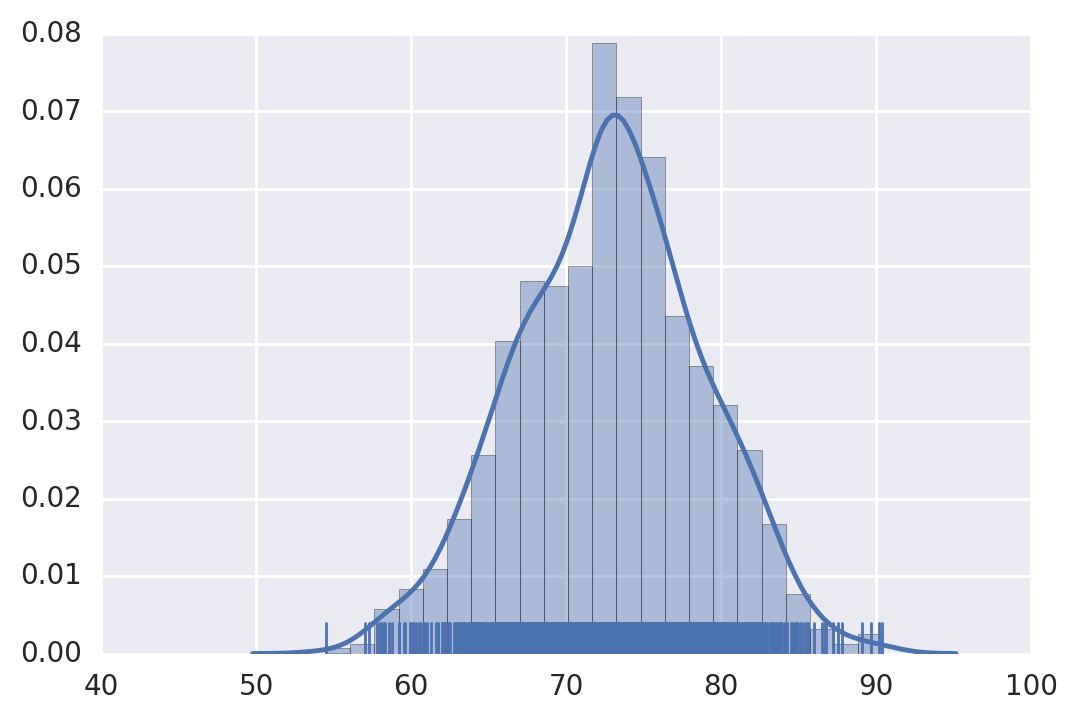

In [171]:
sns.distplot(svr_perm.results, rug=True)

Looks similar. Need to provide context for feature inclusion with Random Forests (the easiest way to tell if then-excluded now-imputed features are making a difference)

In [190]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

X, X_test, Y, Y_test = train_test_split(newdata, data.Y, test_size=0.30)

In [194]:
rfr.fit(scale(X), Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [195]:
importances_std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

importances_ind = np.argsort(rfr.feature_importances_)[::-1]

pp.pprint(list(zip(data.feature_names[importances_ind].values, rfr.feature_importances_[importances_ind])))

[('Bio1_mean_nosyn', 0.090817462304847704),
 ('latest_seed_shed_mo', 0.086344785497959431),
 ('Nbound_lat_GBIF_nosyn', 0.075460180123768303),
 ('Bio1_std_nosyn', 0.073195424372320655),
 ('Bio1_mean_inclsyn', 0.059089179148742579),
 ('Bio1_var_inclsyn', 0.053510532519233253),
 ('earliest_seed_shed_mo', 0.043615921033749901),
 ('Ave_seed_shed_ht_m', 0.04158364191764069),
 ('Bio1_var_nosyn', 0.034284402997946779),
 ('flwr_mo_start', 0.033183445656338538),
 ('Min_seed_shed_ht_m', 0.033129498420123901),
 ('flwr_dur_mos', 0.030560128034119331),
 ('flwr_mo_end', 0.028199016393339538),
 ('seed_mass_mg', 0.027066958583380395),
 ('diaspore_max_len_mm', 0.025312684335336223),
 ('Bio1_std_inclsyn', 0.023135425845111437),
 ('Max_seed_shed_ht_m', 0.019205914403502548),
 ('dispersal_mode_wind', 0.019118099838228157),
 ('diaspore_min_len_mm', 0.018849031471843282),
 ('BreedSysCode_4.0', 0.017321411681581977),
 ('SI01', 0.017097467241760745),
 ('seed_shed_dur_mos', 0.016067070583799001),
 ('diaspore_ma

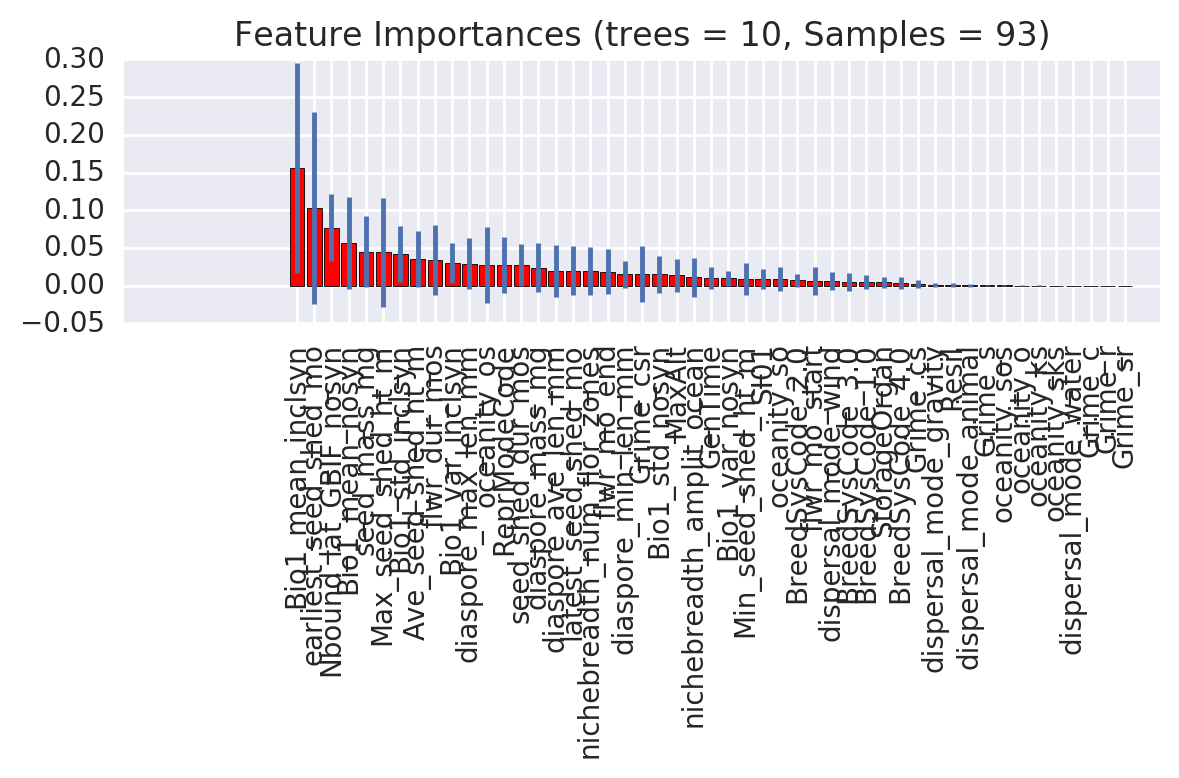

In [182]:
f, ax = plt.subplots()
bar_indices = np.arange(X.shape[1])
bar_width = 0.85

plt.title("Feature Importances (trees = {}, Samples = {})".format(rfr.get_params()["n_estimators"], len(X)))
plt.bar(bar_indices,
        rfr.feature_importances_[importances_ind],
        bar_width,
        color='r',
        yerr=importances_std[importances_ind],
        align='center', bottom=0)

plt.xticks(bar_indices, data.feature_names[importances_ind], rotation=90)
plt.tight_layout()
plt.show()

This is a nice result, quite surprising. The imputation didn't do much to the overall score, but certainly shed some light on important, interesting features. Going to add this information to feature importance analysis from 2/14. 

In [ ]:
[]